In [1]:
import seaborn as sns
import sncosmo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sncosmo.salt2utils import BicubicInterpolator
from scipy.interpolate import (
    InterpolatedUnivariateSpline as Spline1d,
    RectBivariateSpline as Spline2d
)
import pickle as pk
from matplotlib.backends.backend_pdf import PdfPages
import os 
from matplotlib.offsetbox import AnchoredText
import astropy.constants as const
import astropy.units as u
from matplotlib.ticker import ScalarFormatter

H_ERG_S = const.h.cgs.value
C_AA_PER_S = const.c.to(u.AA / u.s).value
HC_ERG_AA = H_ERG_S * C_AA_PER_S
SCALE_FACTOR = 1e-12

sns.set_style("whitegrid", {'axes.grid':'False','xtick.bottom': True,'ytick.left': True})

params = {"text.usetex" : True,'font.size': 20, 'font.family':'serif', 'font.serif':'Computer Modern'}
plt.rcParams.update(params)


In [2]:
class ScalarFormatterClass1(ScalarFormatter):
    def _set_format(self):
        self.format = "%1.1f"

## Comentários

In [3]:
#

## Recuperando curvas de luz

In [4]:
path="./light_curves/Pantheon/Pantheon_LOWZ_TEXT/"

In [5]:
l=[]
with open(path+"Pantheon_LOWZ_TEXT.README",'r') as f:
    for line in f:
        l.append(line.split())

In [6]:
sne_pass_cut=[l[9:181][i][0] for i in range(0,len(l[9:181]))]

In [7]:
len(sne_pass_cut)

172

## Decodificando filtros

In [8]:
filters_dict={"CFA3S": {"a":"U", "b":"B", "c":"V", "d":"R", "e":"I"},
"CFA3K": {"f":"U", "g":"B", "h":"V", "i":"r", "j":"i"},
"CFA4p1": {"k":"U", "l":"B", "m":"V", "n":"r", "o":"i"},
"CFA4p2": {"p":"B", "q":"V", "r":"r", "s":"i"},
"CSP": {"t":"u", "u":"B", "v":"V_LC3009", "w":"V_LC3014", "x":"V_LC9844", "y":"g", "z":"r","A":"i"},
"CFA1": {"B":"ux", "C":"b", "D":"v", "E":"r", "F":"i"}, 
"CFA2": {"G":"ux", "H":"b", "I":"v", "J":"r", "K":"i"}}

In [9]:
def path_filter(f):
    path_f="/home/cassia/SNANA/snroot/filters/PS1/Pantheon"
    
    filters_path={"CFA3S": path_f+"/CFA3_native/SNLS3_4shooter2_"+f+".dat", 
    # U B V R I ///// unit: COUNT
     
    "CFA3K": path_f+"/PS1_CFA4/cfa4_"+f+"_p1.dat",              
    # U B V r i ///// unit: COUNT
                  
    "CFA4p1": path_f+"/PS1_CFA4/cfa4_"+f+"_p1.dat", 
    # U B V r i ///// unit: COUNT
                  
    "CFA4p2": path_f+"/PS1_CFA4/cfa4_"+f+"_p2.dat", 
    # B V r i ///// unit: COUNT
    
    "CSP": path_f+"/CSP_Str11/"+f+"_texas_WLcorr_atm.txt", 
    # u B V_LC3009 V_LC3014 V_LC9844 g r i ///// unit: COUNT
    
    "CFA1": path_f+"/SNLS3-Landolt/s"+f+"-shifted.dat_5A", 
    # ux b v r i  ///// unit: COUNT
    
    "CFA2": path_f+"/SNLS3-Landolt/s"+f+"-shifted.dat_5A"} 
    # ux b v r i ///// unit: COUNT
    
    return filters_path

## Registrando filtros e criando sistema de magnitude composto

In [10]:
for surv in filters_dict:
    for filt in filters_dict[surv].values():

        wave = pd.read_csv(path_filter(filt)[surv],header=None,sep="\s+",comment="#")[0].values
        trans = pd.read_csv(path_filter(filt)[surv],header=None,sep="\s+",comment="#")[1].values
        band = sncosmo.Bandpass(wave, trans, name=surv+'_'+filt,trim_level=0.05)
        
        sncosmo.registry.register(band)

In [11]:
bd17=sncosmo.get_magsystem('bd17')

In [12]:
magsystem = {"CFA3S":{"CFA3S_U":('bd17',9.6930),
                      "CFA3S_B":('bd17',9.87400-0.0345),
                      "CFA3S_V":('bd17',9.47900-0.0087),
                      "CFA3S_R":('bd17',9.15500-0.021),
                      "CFA3S_I":('bd17',8.85100-0.0136)},
             "CFA3K":{"CFA3K_U":('bd17',9.724),
                      "CFA3K_B":('bd17',9.88605-0.024),
                      "CFA3K_V":('bd17',9.47432-0.0012),
                      "CFA3K_r":('bd17',9.35252+0.0025 ),
                      "CFA3K_i":('bd17',9.25465-0.004)},
             "CFA4p1":{"CFA4p1_U":('bd17',9.724),
                      "CFA4p1_B":('bd17', 9.88605-0.024),
                      "CFA4p1_V":('bd17',9.47432-0.0012),
                      "CFA4p1_r":('bd17',9.35252+0.0025),
                      "CFA4p1_i":('bd17',9.25465-0.004)},
             "CFA4p2":{"CFA4p2_B":('bd17',9.86124+0.0027108700),
                      "CFA4p2_V":('bd17',9.47432-0.0012322002),
                      "CFA4p2_r":('bd17',9.35730+0.0058652098),
                      "CFA4p2_i":('bd17',9.25521-0.0042374653)},
             "CSP":{"CSP_u":('bd17',10.51952),
                      "CSP_B":('bd17', 9.87643-0.0082722800),
                      "CSP_V_LC3009":('bd17',9.47663+0.0017663098),
                      "CSP_V_LC3014":('bd17',9.47128+0.0017663098),
                      "CSP_V_LC9844":('bd17',9.47748+0.0017663098),
                      "CSP_g":('bd17',9.64406+0.0088273000),
                      "CSP_r":('bd17',9.35160+0.0011820498),
                      "CSP_i":('bd17',9.25000-0.016103720)},
             "CFA1":{"CFA1_ux":('bd17',9.72400),
                      "CFA1_b":('bd17',9.90700),
                      "CFA1_v":('bd17',9.46400),
                      "CFA1_r":('bd17',9.16600),
                      "CFA1_i":('bd17',8.84600)},
             "CFA2":{"CFA2_ux":('bd17',9.72400),
                      "CFA2_b":('bd17',9.90700),
                      "CFA2_v":('bd17',9.46400),
                      "CFA2_r":('bd17',9.16600),
                      "CFA2_i":('bd17',8.84600)},
            }

## Criando modelo EXP

In [13]:
class EXP_LC(sncosmo.Source):
    
    _param_names = ['x0', 'x1', 'x2']
    param_names_latex = ['x_0', 'x_1', 'x_2']
    
    
    def __init__(self, phase, wave, flux0, flux1, flux2, name='EXP', version='2021'):

        self.name = name
        self.version = version
        self._phase = phase
        self._wave = wave
        
        self._model_flux0  = BicubicInterpolator(phase, wave, flux0.T)
        self._model_flux1  = BicubicInterpolator(phase, wave, flux1.T)
        self._model_flux2  = BicubicInterpolator(phase, wave, flux2.T)

        self._parameters = np.array([1, 0, 0])  # initial guess
        

    def _flux(self, phase, wave):
        
        x0, x1, x2= self._parameters
        return x0 * (self._model_flux0(phase, wave) +  x1 * self._model_flux1(phase, wave) +  x2 * self._model_flux2(phase, wave))

In [14]:
gridx2 = np.linspace(-10, 50, 50+10+1, dtype=int)
gridy2 = np.linspace(3400, 8400, int((8400-3400)/10+1), dtype=int)

In [15]:
X, Y = np.meshgrid(gridx2,gridy2)

#### Templates FA

In [16]:
M_fa=[]
for i in range(3):
    M_fa.append(np.loadtxt("../fa/sk_varimax_M"+str(i)+".txt")*SCALE_FACTOR)

#### Templates PCA

In [17]:
M_pca=[]
for i in range(3):
    M_pca.append(np.loadtxt("../pca/M"+str(i)+"_pca.txt")*SCALE_FACTOR)

### Criando os modelos

In [18]:
exp_fa = EXP_LC(gridx2, gridy2, M_fa[0], M_fa[1], M_fa[2])
exp_pca = EXP_LC(gridx2, gridy2, M_pca[0], M_pca[1], M_pca[2])

In [19]:
sncosmo.register(exp_fa,name="exp_fa_varimax")
sncosmo.register(exp_pca,name="exp_pca")

## Escolha do modelo

In [20]:
modelo="exp_fa_varimax"

## Ajustando curvas de luz

In [21]:
def lc_fit(sn):    

    if os.path.exists(path+"CFA3_4SHOOTER2_"+sn+".DAT"):
        meta, tables = sncosmo.read_snana_ascii(path+"CFA3_4SHOOTER2_"+sn+".DAT", default_tablename='OBS') 
        
    elif os.path.exists(path+"CFA3_KEPLERCAM_"+sn+".DAT"):
        meta, tables = sncosmo.read_snana_ascii(path+"CFA3_KEPLERCAM_"+sn+".DAT", default_tablename='OBS')
        
    elif os.path.exists(path+"CFA4_p1_"+sn+".dat"):
        meta, tables = sncosmo.read_snana_ascii(path+"CFA4_p1_"+sn+".dat", default_tablename='OBS')
        
    elif os.path.exists(path+"CFA4_p2_"+sn+".dat"):
        meta, tables = sncosmo.read_snana_ascii(path+"CFA4_p2_"+sn+".dat", default_tablename='OBS')
        
    elif os.path.exists(path+"CSPDR2_"+sn+".dat"):
        meta, tables = sncosmo.read_snana_ascii(path+"CSPDR2_"+sn+".dat", default_tablename='OBS')
        
    elif os.path.exists(path+"LOWZ_JRK07_"+sn+".DAT"):
        meta, tables = sncosmo.read_snana_ascii(path+"LOWZ_JRK07_"+sn+".DAT", default_tablename='OBS')
        
    else:
        print(sn)
    
    dat=tables["OBS"]
    surv=meta["SURVEY"].split("(")[1][:-1]

    dat.add_column([surv+"_"+filters_dict[surv][f] for f in dat["FLT"]], name='FILTER') # decodificando
    dat.remove_column("FLT")
    
    dat.remove_rows(np.where(dat["FILTER"]==surv+"_I")[0])
    dat.remove_rows(np.where(dat["FILTER"]==surv+"_i")[0])
    
    if sn in ["2000fa","2000dk","2000cn","2000B","1999cc","1997E","1996bv","1995ak",
              "1994M","1993ae","2008hv","2007ca","2006lu","2006eq","2006bh","2005kc",
              "2005el","2010Y"]:
        dat.remove_rows(np.where(dat["FILTER"]==surv+"_r")[0])
    
    if sn in ["2008gp"]:
        dat.remove_rows(np.where(dat["FILTER"]==surv+"_g")[0])
    
    dat.remove_rows(np.where(dat["FLUXCAL"]<0)[0])
    dat.remove_rows(np.where(np.isnan(dat["MAG"]))[0])

    magsys=sncosmo.CompositeMagSystem(bands=magsystem[surv],name="magsys")
    sncosmo.register(magsys,force=True)
        
    dat["FLUX"]=[magsys.band_mag_to_flux(dat["MAG"][i],dat["FILTER"][i]) for i in range(len(dat["MAG"]))]
    dat["FLUXERR"]=[abs(0.4*dat["FLUX"][i]*np.log(10.)*dat["MAGERR"][i]) for i in range(len(dat["MAG"]))]
    dat.remove_columns(["FIELD","MAG","MAGERR"])
    
    #dat.remove_rows(np.where(dat["FLUX"]/dat["FLUXERR"]<5)[0])

    # ref de repouso: (t-t0)/(1+z), no SNANA fazem um corte de -15 a 45 no referencial de repouso. E também tem um corte no 
    # intervalo de comprimento de onda, eu apliquei esses cortes abaixo em phase_range e wave_range. Porém não tenho certeza
    # se o sncosmo corta no ref de repouso ou do observador. Alterando isso, os valores de x1 para 2001ah e 2001az mudam drasticamento
    # equivalendo a mesma mudança que ocorre no snana quando fazemos a mesma alteração no TREST_REJECT.    
    
    dat["ZP"]=[2.5*np.log10(magsys.zpbandflux(f)) for f in dat["FILTER"]]
    dat.add_column("magsys", name='ZPSYS')
    
    dust = sncosmo.F99Dust() 

    # para algumas sne como 2006bb o chi2 da minimizacao da Nan e não é possível ajustar a sn. A mesma sn no snana é ajustada pelo salt.
    # alterando intervalo de dias e comprimento de onda de atuação do ajustador, ainda não é possível evitar o nan já no primeiro passo.
      
    model = sncosmo.Model(source=modelo,effects=[dust],effect_names=['mw'],effect_frames=['obs'])
    model.set(z=meta["REDSHIFT_FINAL"],mwebv=meta["MWEBV"])
    try:
        result, fitted_model = sncosmo.fit_lc(dat, model, ['t0','x0', 'x1', 'x2'],bounds={"t0":(meta["SEARCH_PEAKMJD"]-5,meta["SEARCH_PEAKMJD"]+5)},modelcov=False, phase_range=(-10, 40.), wave_range=(3400.,7000.), verbose=False)
        #bounds={"t0":(meta["SEARCH_PEAKMJD"]-10,meta["SEARCH_PEAKMJD"]+10),"x1":(-5.,5.),"x2":(-5.,5.)}
    except:
        print(f"SN {sn} fit returns NaN")
        result=None
        fitted_model=None
    
    return meta, surv, dat, result, fitted_model

In [22]:
pp = PdfPages(f"./lc_fit_plot_{modelo.upper()}_LOWZ_Pantheon.pdf")

In [23]:
colors1=["#440154"]
colors2=["#fde725","#440154"]
colors3=["#fde725","#21918c","#440154"]
colors4=["#fde725","#35b779","#31688e","#440154"]

In [24]:
def lc_fit_plot(sn, surv,table_data, result, fitted_model):
    z=round(result["parameters"][0],2)
    t0=round(result["parameters"][1],2)
    x1=round(result["parameters"][3],2)
    x1err=round(result["errors"]["x1"],2)
    x2=round(result["parameters"][4],2)
    x2err=round(result["errors"]["x2"],2)
    mwebv=result["parameters"][5]
    phase=np.linspace(t0-10.,t0+50.,100)

    if result.ndof>0:
        fil=[]
        for i,f in enumerate(magsystem[surv].keys()): 
            if len(table_data[table_data["FILTER"]==f])==0:
                continue
            else:
                try:
                    fitted_model.bandflux(f, phase)
                    fil.append(f)
                    continue
                except:
                    continue
        fig, axs=plt.subplots(len(fil),1,figsize=(10,4*len(fil)),sharex=True)
        fig.subplots_adjust(hspace=0.1)
        if len(fil)==1:
            for i,f in enumerate(fil): 
                colors=eval("colors"+str(len(fil)))
                axs.plot(phase-t0,fitted_model.bandflux(f, phase)*10**(-0.4*table_data[table_data["FILTER"]==f]["ZP"][0]+11),linewidth=3,color=colors[i],label=f"{modelo.upper()} fit ($\chi^2/ndof$={round(result.chisq/result.ndof,2)})")
                axs.errorbar(table_data[table_data["FILTER"]==f]["MJD"]-t0,table_data[table_data["FILTER"]==f]["FLUXCAL"],yerr=table_data[table_data["FILTER"]==f]["FLUXCALERR"],label=f"Flux through {f} filter",ls="none", marker='o',markersize=8,color=colors[i])
                axs.set_ylabel(r"FLUX ($Z_{AB}$=27.5)")
                axs.set_xlim(-12,52)
                axs.set_title(f"{sn}({surv}),   z:{z:.2f},   x1={x1:.2f}$\pm${x1err:.2f},   x2={x2:.2f}$\pm${x2err:.2f}")
                formatter11=ScalarFormatterClass1()
                formatter11.set_scientific(True)
                formatter11.set_powerlimits((0,0))
                axs.yaxis.set_major_formatter(formatter11)
                axs.legend(loc=3)
                if i==len(fil)-1:
                    axs.set_xlabel(f"MJD-{t0}")
            #plt.show()
            plt.tight_layout()
            pp.savefig()
            plt.close(fig)
        else:
            for i,f in enumerate(fil): 
                colors=eval("colors"+str(len(fil)))
                axs[i].plot(phase-t0,fitted_model.bandflux(f, phase)*10**(-0.4*table_data[table_data["FILTER"]==f]["ZP"][0]+11),linewidth=3,color=colors[i],label=f"{modelo.upper()}  fit ($\chi^2/ndof$={round(result.chisq/result.ndof,2)})")
                axs[i].errorbar(table_data[table_data["FILTER"]==f]["MJD"]-t0,table_data[table_data["FILTER"]==f]["FLUXCAL"],yerr=table_data[table_data["FILTER"]==f]["FLUXCALERR"],label=f"Flux through {f} filter",ls="none", marker='o',markersize=8,color=colors[i])
                axs[i].set_ylabel(r"FLUX ($Z_{AB}$=27.5)")
                axs[i].set_xlim(-12,52)
                axs[i].set_title(f"{sn}({surv}),   z:{z:.2f},   x1={x1:.2f}$\pm${x1err:.2f},   x2={x2:.2f}$\pm${x2err:.2f}")
                formatter11=ScalarFormatterClass1()
                formatter11.set_scientific(True)
                formatter11.set_powerlimits((0,0))
                axs[i].yaxis.set_major_formatter(formatter11)
                axs[i].legend(loc=3)
                if i==len(fil)-1:
                    axs[i].set_xlabel(f"MJD-{t0}")
            #plt.show()
            plt.tight_layout()
            pp.savefig()
            plt.close(fig)
    else:
        pass

In [25]:
 def return_fit_data(meta,res,model_name):

    return [meta["SNID"], meta["SURVEY"], meta["REDSHIFT_FINAL"], 0., res.parameters[1],
           res.errors["t0"], res.parameters[2], res.errors["x0"], res.parameters[3],
           res.errors["x1"], res.parameters[4], res.errors["x2"],
           res.covariance[1][2], res.covariance[1][3], res.covariance[2][3], 
           res.chisq/res.ndof, model_name]

In [26]:
all_fit_data=[]
f=open(f"./lc_failed_fits_{modelo.upper()}_LOWZ_Pantheon.txt","w")
for j,sn in enumerate(sne_pass_cut):
    print(sn, f"({j}/{len(sne_pass_cut)})")
    meta, surv, dat, result, fitted_model=lc_fit(sn) 
    
    if result is None:
        f.write(f"SN {sn} fit returns NaN\n")
        continue
    else:
        if result.success and result.ndof>0:
            all_fit_data.append(return_fit_data(meta,result,f"{modelo.upper()}"))
        elif result.success and result.ndof==0:
            f.write("ndof 0 for SN"+sn+"\n")
        elif not result.success:
            f.write("Unsuccessful fit of SN"+sn+"\n")

    lc_fit_plot(sn, surv, dat, result, fitted_model)     

2001ah (0/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3S_B(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2001az (1/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3S_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2001da (2/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3S_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2001en (3/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3S_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2001fe (4/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3S_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2001gb (5/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2001G (6/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3S_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2001ic (7/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2001V (8/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3S_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2002bf (9/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3S_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2002bz (10/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3S_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2002ck (11/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3S_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2002cr (12/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3S_U, CFA3S_R(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2002de (13/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3S_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2002dp (14/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3S_U, CFA3S_R(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2002eu (15/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3S_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2002G (16/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2002ha (17/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3S_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2002he (18/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3S_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2002kf (19/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3S_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2003ae (20/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2003ch (21/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3S_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2003cq (22/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3S_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2003fa (23/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3S_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2003hu (24/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3S_U, CFA3S_B(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2003ic (25/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3S_U, CFA3S_B(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2003it (26/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3S_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2003iv (27/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3S_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2003U (28/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3S_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2004as (29/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3S_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2004L (30/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3S_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2004ef (31/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3K_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2005hf (32/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3K_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2005hj (33/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3K_B, CFA3K_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2005lz (34/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3K_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2005mc (35/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3K_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2005ms (36/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3K_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2005na (37/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3K_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2006ac (38/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3K_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2006ah (39/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3K_B(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2006ak (40/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2006al (41/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3K_B(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2006ax (42/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3K_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2006bb (43/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3K_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2006bq (44/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3K_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2006bw (45/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2006cj (46/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3K_B, CFA3K_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2006cp (47/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3K_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2006cq (48/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3K_B(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2006en (49/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2006ev (50/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2006gr (51/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3K_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2006gt (52/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2006hb (53/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3K_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2006is (54/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2006je (55/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2006mo (56/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2006mp (57/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2006N (58/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3K_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2006oa (59/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3K_B, CFA3K_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2006ob (60/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3K_B, CFA3K_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2006on (61/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3K_B(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2006or (62/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2006qo (63/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2006sr (64/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3K_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2006td (65/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2006te (66/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2007ae (67/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3K_B(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2007ap (68/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2007ar (69/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3K_B(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2007bd (70/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2007co (71/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3K_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2007cq (72/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2007F (73/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2007O (74/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2008af (75/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2008bf (76/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3K_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2008L (77/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2007A (78/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2007aj (79/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2007cb (80/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2007cc (81/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2007fb (82/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2007hu (83/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2007is (84/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2007kh (85/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA4p1_B(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2007kk (86/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2007nq (87/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2007ob (88/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2007su (89/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2007ux (90/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2008C (91/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2008Y (92/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA4p1_B(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2008ac (93/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA4p1_B(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2008ar (94/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2008at (95/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2008bw (96/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2008by (97/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2008bz (98/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA4p1_B(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2008cf (99/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2008ds (100/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2008fr (101/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2008gb (102/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2008gl (103/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2009D (104/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2009ad (105/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2009an (106/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2009ds (107/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2008050 (108/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2008051 (109/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2009kk (110/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2009kq (111/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2009le (112/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2009na (113/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2009nq (114/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2010A (115/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2010H (116/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2010Y (117/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2010dt (118/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


PTF10bjs (119/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2004eo (120/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CSP_u(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2004ey (121/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CSP_u(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2004gu (122/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CSP_u(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2005be (123/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CSP_u(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2005bo (124/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CSP_u(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2005el (125/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3K_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2005eq (126/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3K_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2005hc (127/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3K_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2005iq (128/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3K_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2005kc (129/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3K_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2005ki (130/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3K_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2005lu (131/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3K_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2005M (132/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3K_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2006bh (133/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CSP_u(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2006ef (134/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2006ej (135/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2006eq (136/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CSP_u(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2006et (137/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2006lu (138/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CSP_u(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2006py (139/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CSP_u(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2007bc (140/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2007ca (141/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2008bq (142/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CSP_u(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2008gp (143/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CSP_u(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2008hv (144/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


1993ac (145/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


1993ae (146/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


1994M (147/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


1994Q (148/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


1994S (149/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


1995ak (150/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


1996bl (151/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


1996bv (152/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


1996C (153/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


1997dg (154/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA2_ux(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


1997E (155/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA2_ux(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


1997Y (156/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA2_ux(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


1998dk (157/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA2_ux(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


1998dx (158/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA2_ux(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


1998ec (159/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA2_ux(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


1998ef (160/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA2_ux(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


1998eg (161/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA2_ux(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


1999cc (162/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA2_ux(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


1999dq (163/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA2_ux(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


1999ef (164/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA2_ux(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


1999ej (165/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA2_ux(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


1999X (166/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA2_ux(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2000B (167/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA2_ux(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2000cf (168/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA2_ux(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2000cn (169/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA2_ux(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2000dk (170/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA2_ux(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2000fa (171/172)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA2_ux(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


In [27]:
pp.close()

In [28]:
f.close()

## Salvando dados dos ajustes

In [29]:
df=pd.DataFrame(all_fit_data)

In [30]:
df=pd.DataFrame(all_fit_data)
df.columns=("SNNAME", "SURVEY", "Z", "ZERR", "T0", "T0ERR", "X0", "X0ERR", "X1", "X1ERR", "X2/C", "X2/CERR", "COV_X0_X1", "COV_X0_X2/C", "COV_X1_X2/C", "CHISQ/NDOF", "MODEL")

In [31]:
df["mB"]=-2.5*np.log10(df["X0"])
df["mBERR"]=np.abs(-2.5*np.log10(np.e)/df["X0"]*df["X0ERR"])
df["COV_mB_X1"]=-2.5*np.log10(np.e)/df["X0"]*df["COV_X0_X1"]
df["COV_mB_X2/C"]=-2.5*np.log10(np.e)/df["X0"]*df["COV_X0_X2/C"]

In [32]:
df.to_csv(f"./lc_fit_results_{modelo.upper()}_LOWZ_Pantheon.txt", sep=' ', index=False)

## Analisando SN que passam nos cortes FA

In [33]:
pass_cosm_cuts=['2001ah',
       '2001az', '2001da', '2001fe', '2001gb', '2001G', '2001ic', '2001V',
       '2002bf', '2002bz', '2002ck', '2002cr', '2002de', '2002dp',
       '2002eu', '2002G', '2002he', '2002kf', '2003ae', '2003ch',
       '2003cq', '2003fa', '2003hu', '2003ic', '2003it', '2003iv',
       '2003U', '2004as', '2004L', '2004ef', '2005hf', '2005hj', '2005lz',
       '2005mc', '2005ms', '2005na', '2006ac', '2006ah', '2006ak',
       '2006al', '2006ax', '2006bb', '2006bw', '2006cj', '2006cp',
       '2006cq', '2006en', '2006ev', '2006gr', '2006hb', '2006is',
       '2006mo', '2006mp', '2006N', '2006oa', '2006ob', '2006on',
       '2006or', '2006sr', '2006td', '2006te', '2007ae', '2007ap',
       '2007ar', '2007bd', '2007co', '2007cq', '2007F', '2007O', '2008af',
       '2008bf', '2007A', '2007aj', '2007cb', '2007cc', '2007fb',
       '2007hu', '2007is', '2007kh', '2007kk', '2007nq', '2007ob',
       '2007su', '2007ux', '2008C', '2008Y', '2008ac', '2008ar', '2008at',
       '2008bw', '2008by', '2008bz', '2008cf', '2008ds', '2008fr',
       '2008gb', '2008gl', '2009D', '2009ad', '2009an', '2009ds',
       '2008050', '2008051', '2009kk', '2009kq', '2009na', '2009nq',
       '2010A', '2010H', '2010dt', 'PTF10bjs', '2004eo', '2004gu',
       '2005be', '2005bo', '2005eq', '2005hc', '2005iq', '2005kc',
       '2005ki', '2005lu', '2006ef', '2006eq', '2006et', '2006lu',
       '2006py', '2007bc', '2008bq', '2008hv', '1993ac', '1993ae',
       '1994M', '1994Q', '1994S', '1995ak', '1996bl', '1996bv', '1996C',
       '1997dg', '1997E', '1997Y', '1998dk', '1998dx', '1998ec', '1998eg',
       '1999cc', '1999dq', '1999ef', '1999ej', '1999X', '2000cf',
       '2000cn', '2000fa']

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: CFA3S_U(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'endStream'

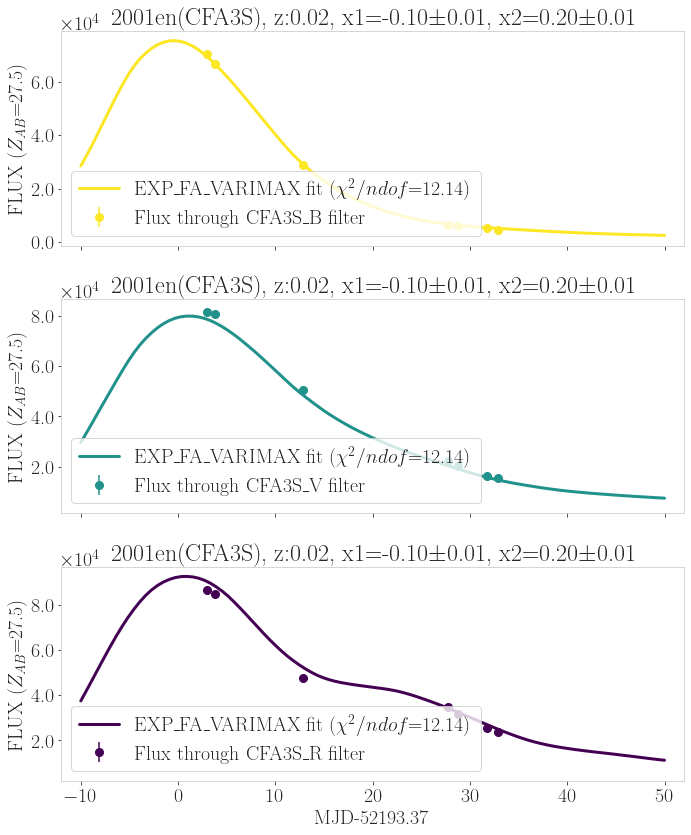

In [34]:
for j,sn in enumerate(sne_pass_cut):
    if sn not in pass_cosm_cuts:
        
        meta, surv, dat, result, fitted_model=lc_fit(sn) 
        
        lc_fit_plot(sn, surv, dat, result, fitted_model)     